In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [59]:
#загрузка данных
data = pd.read_csv('diabetes.csv')
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [60]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

 1. Сравнение моделей логистической регрессии и решающего дерева

In [40]:
# Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

In [41]:
# Решающее дерево (стандартные параметры)
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:, 1]


In [42]:
# Функция для вывода метрик
def print_metrics(y_true, y_pred, y_prob, model_name):
    print(f"\nМетрики для {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.3f}")
    print("\nМатрица ошибок:")
    print(confusion_matrix(y_true, y_pred))
    print("\nОтчет классификации:")
    print(classification_report(y_true, y_pred))

In [43]:
# Вывод метрик для обеих моделей
print_metrics(y_test, y_pred_log, y_prob_log, "логистической регрессии")
print_metrics(y_test, y_pred_tree, y_prob_tree, "решающего дерева")



Метрики для логистической регрессии:
Accuracy: 0.736
Precision: 0.617
Recall: 0.625
F1-score: 0.621
ROC-AUC: 0.796

Матрица ошибок:
[[120  31]
 [ 30  50]]

Отчет классификации:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231


Метрики для решающего дерева:
Accuracy: 0.701
Precision: 0.556
Recall: 0.688
F1-score: 0.615
ROC-AUC: 0.698

Матрица ошибок:
[[107  44]
 [ 25  55]]

Отчет классификации:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       151
           1       0.56      0.69      0.61        80

    accuracy                           0.70       231
   macro avg       0.68      0.70      0.69       231
weighted avg       0.72      0.70      0.71       23

 2. Исследование зависимости F1-score от глубины дерева

In [44]:
max_depths = range(1, 21)
train_scores = []
test_scores = []

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # Оценка на тренировочных данных
    y_train_pred = tree.predict(X_train)
    train_scores.append(f1_score(y_train, y_train_pred))
    
    # Оценка на тестовых данных
    y_test_pred = tree.predict(X_test)
    test_scores.append(f1_score(y_test, y_test_pred))

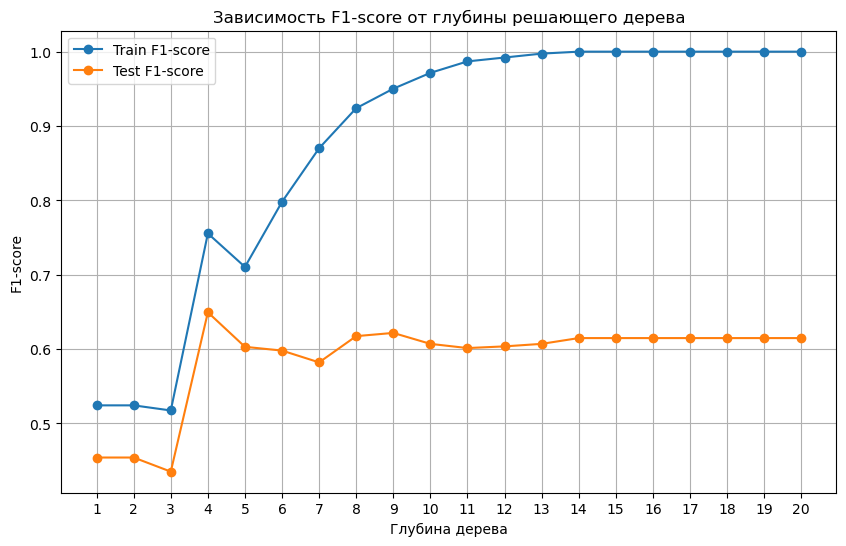

In [45]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Train F1-score', marker='o')
plt.plot(max_depths, test_scores, label='Test F1-score', marker='o')
plt.xlabel('Глубина дерева')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от глубины решающего дерева')
plt.legend()
plt.grid(True)
plt.xticks(max_depths)
plt.show()

In [46]:
# Найдем оптимальную глубину
optimal_depth = max_depths[np.argmax(test_scores)]
print(f"\nОптимальная глубина дерева: {optimal_depth}")


Оптимальная глубина дерева: 4


 3. Анализ модели с оптимальной глубиной

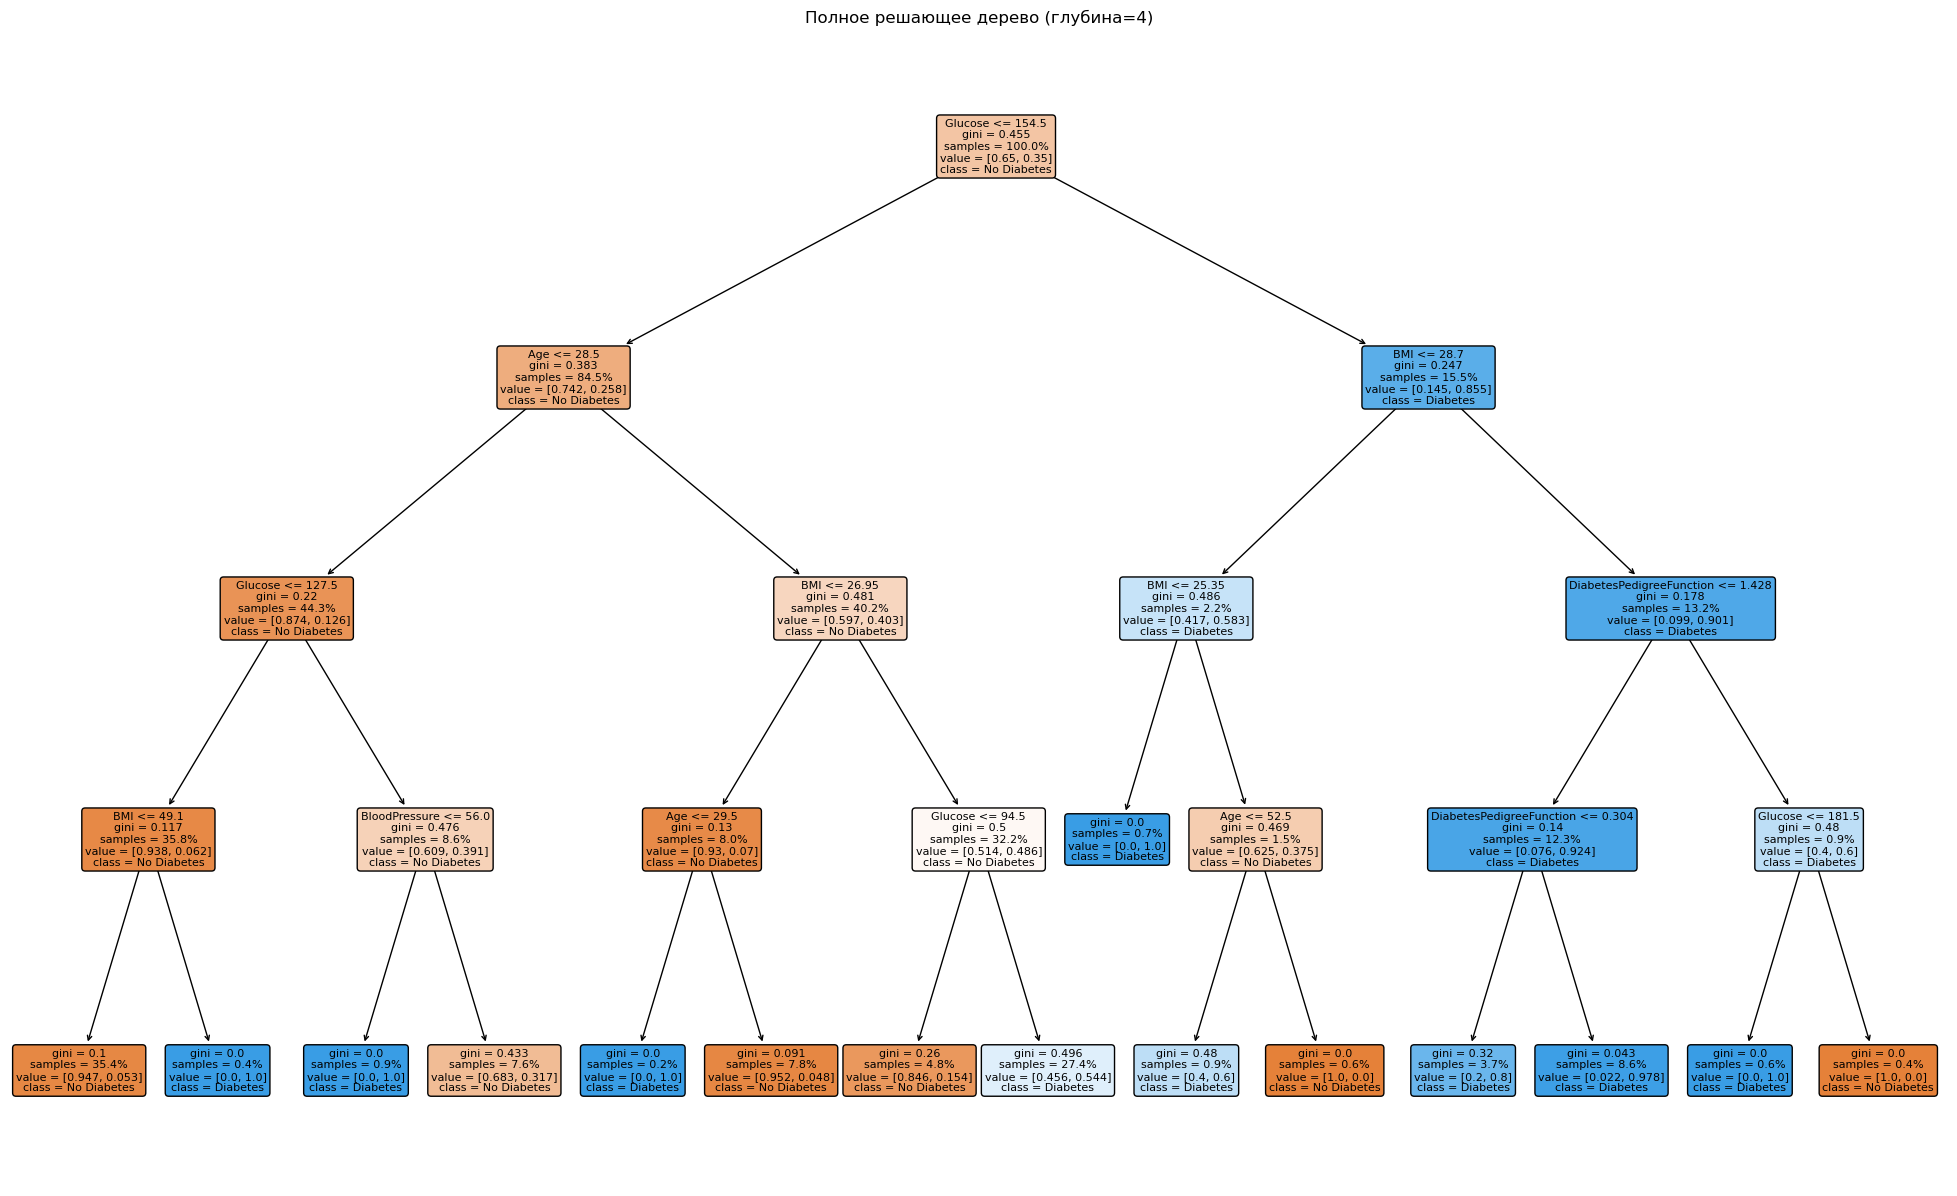

In [54]:
# Обучение оптимального дерева
optimal_tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
optimal_tree.fit(X_train, y_train)

# Визуализация дерева 
plt.figure(figsize=(25, 15))
plot_tree(optimal_tree, 
          feature_names=list(X.columns),  # Преобразуем Index в список
          class_names=['No Diabetes', 'Diabetes'],
          filled=True, 
          rounded=True, 
          proportion=True,
          fontsize=8)  
plt.title(f"Полное решающее дерево (глубина={optimal_depth})")
plt.show()

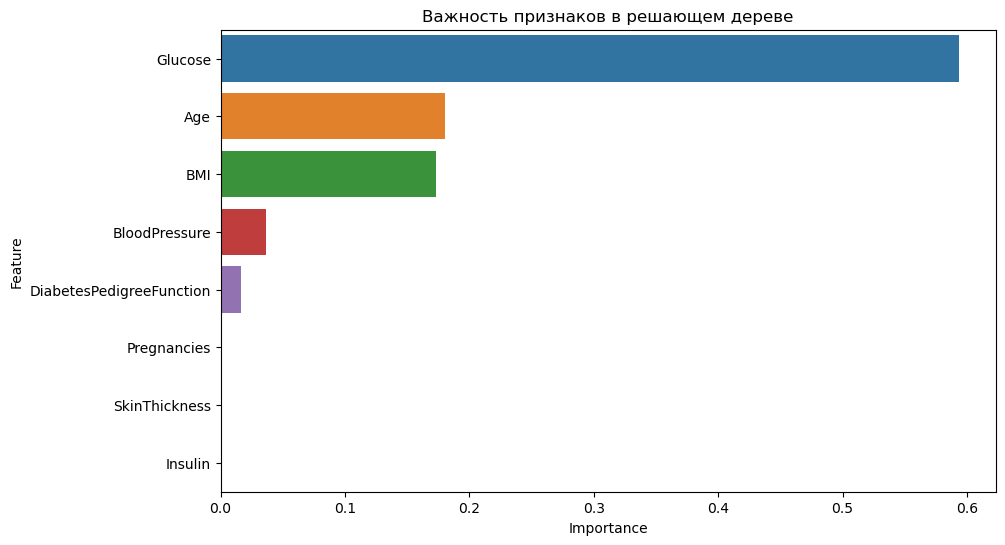

In [55]:
# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': optimal_tree.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков в решающем дереве')
plt.show()

In [56]:
# Прогнозы оптимального дерева
y_pred_optimal = optimal_tree.predict(X_test)
y_prob_optimal = optimal_tree.predict_proba(X_test)[:, 1]

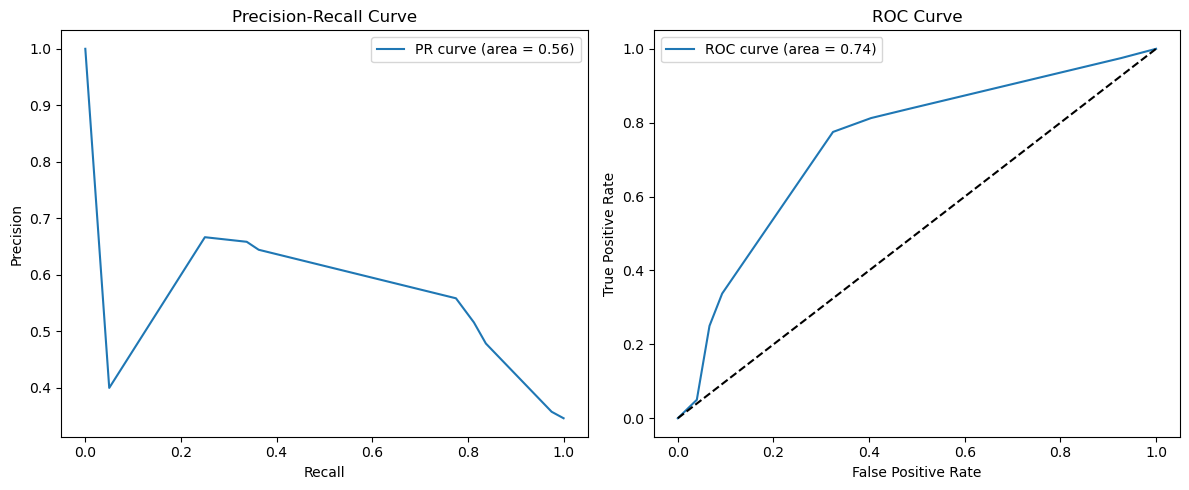

In [57]:
# PR и ROC кривые
plt.figure(figsize=(12, 5))

# PR кривая
plt.subplot(1, 2, 1)
precision, recall, _ = precision_recall_curve(y_test, y_prob_optimal)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# ROC кривая
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob_optimal)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

4. Исследование зависимости от max_features

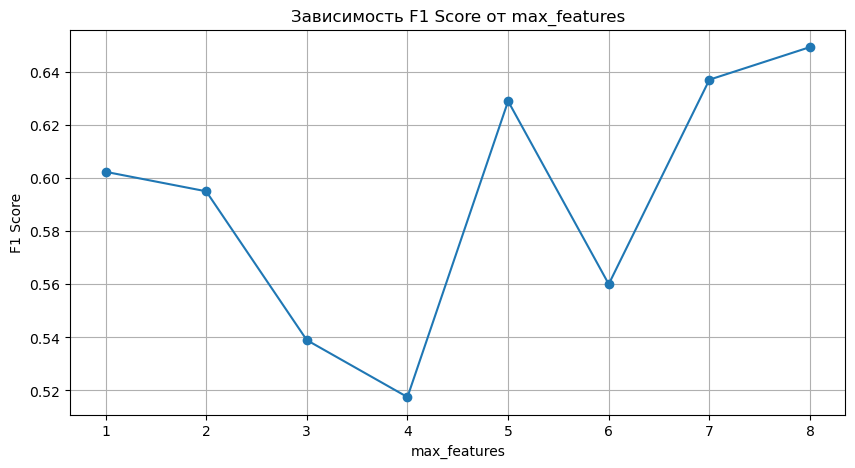

In [36]:
max_features_range = range(1, X.shape[1]+1)
f1_scores_features = []

for n_features in max_features_range:
    tree = DecisionTreeClassifier(max_depth=optimal_depth, 
                                max_features=n_features, 
                                random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    f1_scores_features.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(max_features_range, f1_scores_features, marker='o')
plt.xlabel('max_features')
plt.ylabel('F1 Score')
plt.title('Зависимость F1 Score от max_features')
plt.grid()
plt.xticks(max_features_range)
plt.show()